# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part3 Labeld Face Data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a face given its label. You can draw a black male/black female/white male/white female as you gives an input at the end of training. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load Face datasets
Unzip the face_dataset.tar.gz in data directory as follows.<br>
**cd ./data**<br>
**tar -xf face_dataset.tar.gz**<br>

Following is how to load the data. Modify  *data_dir* to be the directory the data is in. Or you will get an error.<br>

In [1]:
from utils import load_face
data_dir = './data/face_dataset'
im, label = load_face(data_dir)

There are 13143 images and corresponding lables. Labels have three values. Following is the detail:

Label1 - Male/Female : positive value means male<br>
Label2 - White/Not white : positive value means White<br>
Lable3 - Black/Not black : positive value menas black<br>
The large value represents the more property it has.

Note that the labels are not normalized and check the data by runing and modifying following code

In [ ]:
import pylab as plt
for i in range(5):
    plt.imshow(im[i])
    plt.show()
    print(label[i])
    print(im[i].shape)

## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1) generative model (2) discriminative model. You can reuse your code in part1 and improve it. Just write the code in whatever way you find most clear.

In [10]:
from utils import load_face
from utils import getNext_batch
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import sample_label_face
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

learning_rate = 0.0002
batch_size = 128
EPOCH = 100
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 3
channel = 3
output_size = 64

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

It is time for a generative model. You can change anything including the argument If you need. Feel free to change it and improve it.

In [5]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
    #### TODO ####
    with tf.variable_scope('gen'):
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        z_input = tf.reshape(z, [-1, 1, 1, sample_size])
        y_label = tf.reshape(y, [-1, 1, 1, y_dim])
        inputs = tf.concat([z, y], 1)
        
        # project layer
        proj_size = 4*4*1024
        W = tf.get_variable("W0", [sample_size + y_dim, proj_size], initializer=w_init)
        b = tf.get_variable("b0", [proj_size], initializer=b_init)
        projected = lrelu(batch_normal(fully_connect(inputs, W, b), scope='bn0'))
        reshape = tf.reshape(projected, [batch_size, 4, 4, 1024])

        # 1st hidden layer
        W = tf.get_variable("W1", [5, 5, 512, 1024], initializer=w_init)
        b = tf.get_variable("b1", [512], initializer=b_init)
        deconv1 = lrelu(batch_normal(de_conv(reshape, W, b, [batch_size, 8, 8, 512]), scope='bn1'))

        # 2nd hidden layer
        W = tf.get_variable("W2", [5, 5, 256, 512], initializer=w_init)
        b = tf.get_variable("b2", [256], initializer=b_init)
        deconv2 = lrelu(batch_normal(de_conv(deconv1, W, b, [batch_size, 16, 16, 256]), scope='bn2'))
        
        # 3nd hidden layer
        W = tf.get_variable("W3", [5, 5, 128, 256], initializer=w_init)
        b = tf.get_variable("b3", [128], initializer=b_init)
        deconv3 = lrelu(batch_normal(de_conv(deconv2, W, b, [batch_size, 32, 32, 128]), scope='bn3'))

        # output layer
        W = tf.get_variable("W4", [5, 5, 3, 128], initializer=w_init)
        b = tf.get_variable("b4", [3], initializer=b_init)
        deconv3 = de_conv(deconv3, W, b, [batch_size, 64, 64, 3])
        o = tf.nn.tanh(deconv3)

        return o
    

Now, it's time for a discriminative model. Again, you can change anything if you need

In [6]:
def dis_net(data_array , y, batch_size, y_dim, reuse=False):
    #### TODO ####
    with tf.variable_scope('dis', reuse=reuse):
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        yb = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(data_array, yb)

        # 1st hidden layer
        W = tf.get_variable("W1", [5, 5, x.get_shape()[-1], channel+y_dim], initializer=w_init)
        b = tf.get_variable("b1", [channel+y_dim], initializer=b_init)
        conv1 = lrelu(conv2d(x, W, b))
        
        # 2nd hidden layer
        W = tf.get_variable("W2", [5, 5, conv1.get_shape()[-1], 64], initializer=w_init)
        b = tf.get_variable("b2", [64], initializer=b_init)
        conv2 = lrelu(batch_normal(conv2d(conv1, W, b), scope='bn2'))
        conv2_flatten = tf.reshape(conv2, [batch_size, -1])
        
        # 3rd hidden layer
        W = tf.get_variable("W3", [conv2_flatten.get_shape()[-1], 1024], initializer=w_init)
        b = tf.get_variable("b3", [1024], initializer=b_init)
        out3 = lrelu(batch_normal(fully_connect(conv2_flatten, W, b), scope='bn3'))

        # output layer
        W = tf.get_variable("W4", [1024, 1], initializer=w_init)
        b = tf.get_variable("b4", [1], initializer=b_init)
        logits = fully_connect(out3, W, b)
        o = tf.nn.sigmoid(logits)

        return o, logits


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. Then run the code and check the model draws the face properly.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

In [7]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

sample_dir = 'samples_for_test_faces'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Feel free to fill in the main part. You can copy the part1 code or write your own code.

Your goal is to **generate 4 row and 8 column images(32 total)**.

**Each row should correspond to each label**.

First row : black male<br>
Second row: black female<br>
Third row : white male<br>
Fourth row: white female<br>

You can use "save_images" method in *utils.py* to align generated image by 4*8. See part1 code to get how to use it.

You must show **at least three generated images**. (At the beginning of ,in the midway of, at the end of training.)


EPOCH 0 step 50: D: loss = 1.3996160 G: loss=0.6708941 
EPOCH 0 step 100: D: loss = 1.3964567 G: loss=0.6766363 


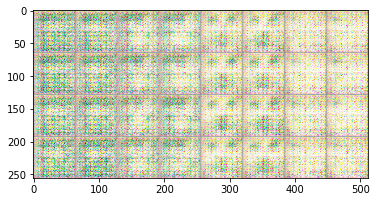

EPOCH 1 step 150: D: loss = 1.3964400 G: loss=0.6929590 
EPOCH 1 step 200: D: loss = 1.3858104 G: loss=0.6885780 
EPOCH 2 step 250: D: loss = 1.3863480 G: loss=0.7055897 
EPOCH 2 step 300: D: loss = 1.3878851 G: loss=0.6941952 
EPOCH 3 step 350: D: loss = 1.3888485 G: loss=0.6816819 
EPOCH 3 step 400: D: loss = 1.3857358 G: loss=0.6839699 
EPOCH 4 step 450: D: loss = 1.3914257 G: loss=0.6914274 
EPOCH 4 step 500: D: loss = 1.3861721 G: loss=0.6949087 
EPOCH 5 step 550: D: loss = 1.3839629 G: loss=0.7010819 
EPOCH 5 step 600: D: loss = 1.3851166 G: loss=0.7005547 
EPOCH 6 step 650: D: loss = 1.3862039 G: loss=0.6901926 
EPOCH 6 step 700: D: loss = 1.3815458 G: loss=0.6915989 
EPOCH 7 step 750: D: loss = 1.3895152 G: loss=0.6745179 
EPOCH 7 step 800: D: loss = 1.3846351 G: loss=0.6921130 
EPOCH 8 step 850: D: loss = 1.3854178 G: loss=0.6888611 
EPOCH 8 step 900: D: loss = 1.3847361 G: loss=0.6968591 
EPOCH 9 step 950: D: loss = 1.3857195 G: loss=0.6883582 
EPOCH 9 step 1000: D: loss = 1.

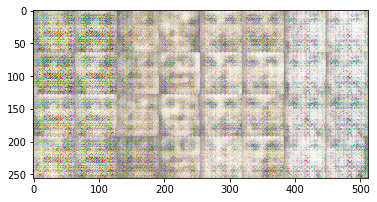

EPOCH 11 step 1150: D: loss = 1.3882883 G: loss=0.6959018 
EPOCH 11 step 1200: D: loss = 1.3798881 G: loss=0.6952884 
EPOCH 12 step 1250: D: loss = 1.3862100 G: loss=0.6930829 
EPOCH 12 step 1300: D: loss = 1.3860152 G: loss=0.6939649 
EPOCH 13 step 1350: D: loss = 1.3891184 G: loss=0.6928883 
EPOCH 13 step 1400: D: loss = 1.3811424 G: loss=0.6993781 
EPOCH 14 step 1450: D: loss = 1.3889273 G: loss=0.6876062 
EPOCH 14 step 1500: D: loss = 1.3814127 G: loss=0.6921549 
EPOCH 15 step 1550: D: loss = 1.3858857 G: loss=0.6872265 
EPOCH 15 step 1600: D: loss = 1.3832772 G: loss=0.6898367 
EPOCH 16 step 1650: D: loss = 1.3797491 G: loss=0.7024714 
EPOCH 16 step 1700: D: loss = 1.3816642 G: loss=0.6963668 
EPOCH 17 step 1750: D: loss = 1.3855649 G: loss=0.6883416 
EPOCH 17 step 1800: D: loss = 1.3835421 G: loss=0.7000757 
EPOCH 18 step 1850: D: loss = 1.3830092 G: loss=0.6884850 
EPOCH 18 step 1900: D: loss = 1.3870118 G: loss=0.6947451 
EPOCH 19 step 1950: D: loss = 1.3803647 G: loss=0.693293

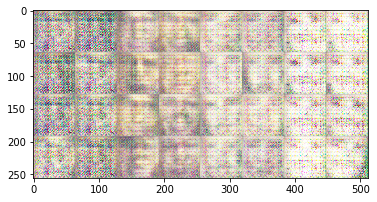

EPOCH 21 step 2150: D: loss = 1.3849583 G: loss=0.6903681 
EPOCH 21 step 2200: D: loss = 1.3804486 G: loss=0.6880586 
EPOCH 22 step 2250: D: loss = 1.3824291 G: loss=0.6980464 
EPOCH 22 step 2300: D: loss = 1.3880860 G: loss=0.6993307 
EPOCH 23 step 2350: D: loss = 1.3813924 G: loss=0.6941679 
EPOCH 23 step 2400: D: loss = 1.3771340 G: loss=0.6964734 
EPOCH 24 step 2450: D: loss = 1.3737679 G: loss=0.6919419 
EPOCH 24 step 2500: D: loss = 1.3693116 G: loss=0.6945709 
EPOCH 24 step 2550: D: loss = 1.3778791 G: loss=0.6984625 
EPOCH 25 step 2600: D: loss = 1.3815086 G: loss=0.6833723 
EPOCH 25 step 2650: D: loss = 1.3844239 G: loss=0.6945952 
EPOCH 26 step 2700: D: loss = 1.3972294 G: loss=0.7030962 
EPOCH 26 step 2750: D: loss = 1.3758237 G: loss=0.6935019 
EPOCH 27 step 2800: D: loss = 1.3817651 G: loss=0.6942623 
EPOCH 27 step 2850: D: loss = 1.3696797 G: loss=0.6897963 
EPOCH 28 step 2900: D: loss = 1.3659017 G: loss=0.6927173 
EPOCH 28 step 2950: D: loss = 1.3714645 G: loss=0.690442

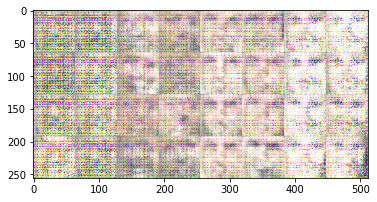

EPOCH 31 step 3200: D: loss = 1.3736267 G: loss=0.7003556 
EPOCH 31 step 3250: D: loss = 1.3736827 G: loss=0.6981859 
EPOCH 32 step 3300: D: loss = 1.3530025 G: loss=0.6964453 
EPOCH 32 step 3350: D: loss = 1.3628607 G: loss=0.7032705 
EPOCH 33 step 3400: D: loss = 1.3303466 G: loss=0.7000010 
EPOCH 33 step 3450: D: loss = 1.3723081 G: loss=0.6898062 
EPOCH 34 step 3500: D: loss = 1.3324559 G: loss=0.6983544 
EPOCH 34 step 3550: D: loss = 1.3719953 G: loss=0.7007208 
EPOCH 35 step 3600: D: loss = 1.3597047 G: loss=0.6973935 
EPOCH 35 step 3650: D: loss = 1.3739316 G: loss=0.7022814 
EPOCH 36 step 3700: D: loss = 1.3463678 G: loss=0.7062238 
EPOCH 36 step 3750: D: loss = 1.3452990 G: loss=0.6961723 
EPOCH 37 step 3800: D: loss = 1.3419719 G: loss=0.7124174 
EPOCH 37 step 3850: D: loss = 1.3630087 G: loss=0.6999745 
EPOCH 38 step 3900: D: loss = 1.3329169 G: loss=0.7020919 
EPOCH 38 step 3950: D: loss = 1.3463398 G: loss=0.7102864 
EPOCH 39 step 4000: D: loss = 1.3294692 G: loss=0.714023

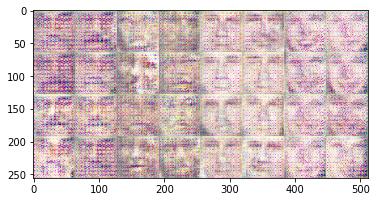

EPOCH 41 step 4200: D: loss = 1.2718415 G: loss=0.7223445 
EPOCH 41 step 4250: D: loss = 1.3156867 G: loss=0.7151874 
EPOCH 42 step 4300: D: loss = 1.3222520 G: loss=0.7287401 
EPOCH 42 step 4350: D: loss = 1.3158516 G: loss=0.7207756 
EPOCH 43 step 4400: D: loss = 1.3216996 G: loss=0.7352108 
EPOCH 43 step 4450: D: loss = 1.2760680 G: loss=0.7375798 
EPOCH 44 step 4500: D: loss = 1.2567611 G: loss=0.7441815 
EPOCH 44 step 4550: D: loss = 1.2687893 G: loss=0.7188528 
EPOCH 45 step 4600: D: loss = 1.2409019 G: loss=0.7519248 
EPOCH 45 step 4650: D: loss = 1.2597681 G: loss=0.7367122 
EPOCH 46 step 4700: D: loss = 1.2029612 G: loss=0.7616346 
EPOCH 46 step 4750: D: loss = 1.2691277 G: loss=0.7739847 
EPOCH 47 step 4800: D: loss = 1.2256800 G: loss=0.7585704 
EPOCH 47 step 4850: D: loss = 1.2320440 G: loss=0.7782116 
EPOCH 48 step 4900: D: loss = 1.2139001 G: loss=0.7636757 
EPOCH 48 step 4950: D: loss = 1.1754019 G: loss=0.7720197 
EPOCH 49 step 5000: D: loss = 1.1459600 G: loss=0.786778

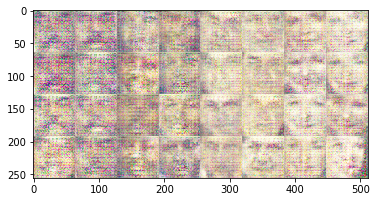

EPOCH 51 step 5250: D: loss = 1.1889288 G: loss=0.8416306 
EPOCH 51 step 5300: D: loss = 1.2288234 G: loss=0.8513896 
EPOCH 52 step 5350: D: loss = 1.1948081 G: loss=0.8496093 
EPOCH 52 step 5400: D: loss = 1.0863208 G: loss=0.8167711 
EPOCH 53 step 5450: D: loss = 1.0918632 G: loss=0.8112015 
EPOCH 53 step 5500: D: loss = 1.1480021 G: loss=0.8269114 
EPOCH 54 step 5550: D: loss = 1.0573769 G: loss=0.7977583 
EPOCH 54 step 5600: D: loss = 1.1557189 G: loss=0.8399572 
EPOCH 55 step 5650: D: loss = 1.0912628 G: loss=0.8268062 
EPOCH 55 step 5700: D: loss = 1.1111808 G: loss=0.9165910 
EPOCH 56 step 5750: D: loss = 1.0655117 G: loss=0.8413864 
EPOCH 56 step 5800: D: loss = 1.1961287 G: loss=0.9046448 
EPOCH 57 step 5850: D: loss = 1.0130277 G: loss=0.8857694 
EPOCH 57 step 5900: D: loss = 1.1494789 G: loss=0.9350172 
EPOCH 58 step 5950: D: loss = 1.0311908 G: loss=0.9420394 
EPOCH 58 step 6000: D: loss = 1.0016340 G: loss=0.8842156 
EPOCH 59 step 6050: D: loss = 1.0108848 G: loss=0.935345

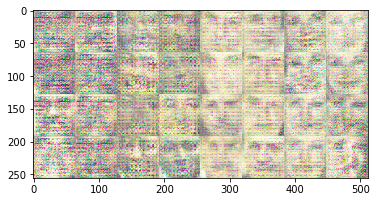

EPOCH 61 step 6250: D: loss = 1.0674551 G: loss=0.9574041 
EPOCH 61 step 6300: D: loss = 0.9476759 G: loss=0.9013754 
EPOCH 62 step 6350: D: loss = 0.9334100 G: loss=0.9682419 
EPOCH 62 step 6400: D: loss = 1.0170934 G: loss=0.9416196 
EPOCH 63 step 6450: D: loss = 0.8707165 G: loss=0.9611636 
EPOCH 63 step 6500: D: loss = 0.9540528 G: loss=0.9779446 
EPOCH 64 step 6550: D: loss = 0.9165536 G: loss=0.9860052 
EPOCH 64 step 6600: D: loss = 0.9481876 G: loss=0.9805335 
EPOCH 65 step 6650: D: loss = 0.9457266 G: loss=0.9930972 
EPOCH 65 step 6700: D: loss = 0.9142245 G: loss=0.9425827 
EPOCH 66 step 6750: D: loss = 0.8699392 G: loss=1.0273519 
EPOCH 66 step 6800: D: loss = 0.9234972 G: loss=0.9268398 
EPOCH 67 step 6850: D: loss = 0.8782293 G: loss=1.0309898 
EPOCH 67 step 6900: D: loss = 0.9012614 G: loss=0.9618652 
EPOCH 68 step 6950: D: loss = 0.9169987 G: loss=1.0258775 
EPOCH 68 step 7000: D: loss = 0.9359408 G: loss=1.0202522 
EPOCH 69 step 7050: D: loss = 0.8349915 G: loss=1.081880

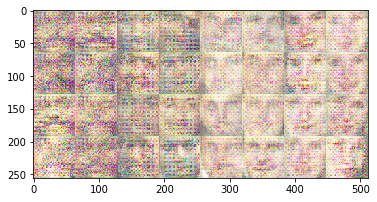

EPOCH 71 step 7250: D: loss = 0.7574603 G: loss=1.0530032 
EPOCH 71 step 7300: D: loss = 0.9130573 G: loss=1.0611553 
EPOCH 72 step 7350: D: loss = 0.8075948 G: loss=1.0500677 
EPOCH 72 step 7400: D: loss = 0.8340611 G: loss=1.0954506 
EPOCH 73 step 7450: D: loss = 0.8131345 G: loss=1.0398767 
EPOCH 73 step 7500: D: loss = 0.7822348 G: loss=1.1181380 
EPOCH 74 step 7550: D: loss = 0.7905324 G: loss=1.0760587 
EPOCH 74 step 7600: D: loss = 0.8565996 G: loss=1.1699836 
EPOCH 74 step 7650: D: loss = 0.8116935 G: loss=1.1030653 
EPOCH 75 step 7700: D: loss = 0.7254670 G: loss=1.1698725 
EPOCH 75 step 7750: D: loss = 0.7965010 G: loss=1.0683063 
EPOCH 76 step 7800: D: loss = 0.9486763 G: loss=1.3174534 
EPOCH 76 step 7850: D: loss = 0.7735189 G: loss=1.1519947 
EPOCH 77 step 7900: D: loss = 0.7725493 G: loss=1.2324952 
EPOCH 77 step 7950: D: loss = 0.6732746 G: loss=1.1630590 
EPOCH 78 step 8000: D: loss = 0.7557636 G: loss=1.1555524 
EPOCH 78 step 8050: D: loss = 0.8994315 G: loss=1.171726

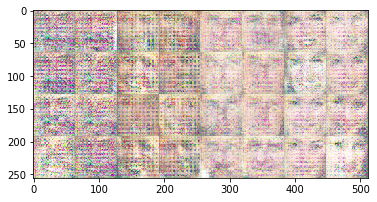

EPOCH 81 step 8300: D: loss = 0.7103346 G: loss=1.2160957 
EPOCH 81 step 8350: D: loss = 0.8273923 G: loss=1.2675307 
EPOCH 82 step 8400: D: loss = 0.6654992 G: loss=1.2469091 
EPOCH 82 step 8450: D: loss = 0.6721286 G: loss=1.2176833 
EPOCH 83 step 8500: D: loss = 0.5779923 G: loss=1.2607889 
EPOCH 83 step 8550: D: loss = 0.6437572 G: loss=1.2339091 
EPOCH 84 step 8600: D: loss = 0.5900875 G: loss=1.1962268 
EPOCH 84 step 8650: D: loss = 0.6903312 G: loss=1.2590252 
EPOCH 85 step 8700: D: loss = 0.7293870 G: loss=1.2065617 
EPOCH 85 step 8750: D: loss = 0.6311015 G: loss=1.2448914 
EPOCH 86 step 8800: D: loss = 0.6773975 G: loss=1.3034033 
EPOCH 86 step 8850: D: loss = 0.6126826 G: loss=1.3114982 
EPOCH 87 step 8900: D: loss = 0.6086414 G: loss=1.2742546 
EPOCH 87 step 8950: D: loss = 0.6264239 G: loss=1.2717724 
EPOCH 88 step 9000: D: loss = 0.5885518 G: loss=1.2932627 
EPOCH 88 step 9050: D: loss = 0.6608748 G: loss=1.2577136 
EPOCH 89 step 9100: D: loss = 0.7615844 G: loss=1.416349

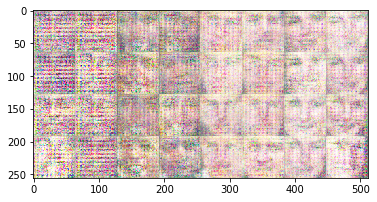

EPOCH 91 step 9300: D: loss = 0.5227771 G: loss=1.3082470 
EPOCH 91 step 9350: D: loss = 0.6300051 G: loss=1.3062015 
EPOCH 92 step 9400: D: loss = 0.5843416 G: loss=1.2573805 
EPOCH 92 step 9450: D: loss = 0.6842052 G: loss=1.3391223 
EPOCH 93 step 9500: D: loss = 0.6506968 G: loss=1.3082120 
EPOCH 93 step 9550: D: loss = 0.5464220 G: loss=1.3803943 
EPOCH 94 step 9600: D: loss = 0.5447806 G: loss=1.4215062 
EPOCH 94 step 9650: D: loss = 0.7580481 G: loss=1.4561586 
EPOCH 95 step 9700: D: loss = 0.5755141 G: loss=1.2738786 
EPOCH 95 step 9750: D: loss = 1.0140002 G: loss=1.6091805 
EPOCH 96 step 9800: D: loss = 0.5351206 G: loss=1.3266294 
EPOCH 96 step 9850: D: loss = 0.6299126 G: loss=1.4704581 
EPOCH 97 step 9900: D: loss = 0.5797076 G: loss=1.3729459 
EPOCH 97 step 9950: D: loss = 0.5657240 G: loss=1.3549180 
EPOCH 98 step 10000: D: loss = 0.5498779 G: loss=1.3838897 
EPOCH 98 step 10050: D: loss = 0.4804189 G: loss=1.4700916 
EPOCH 99 step 10100: D: loss = 0.5044754 G: loss=1.454

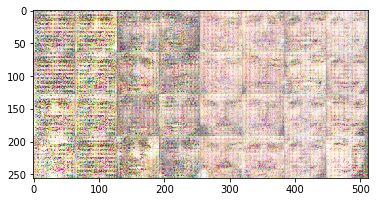

In [11]:
#### TODO ####
def new_sample_label_face(num):
    label_vector = np.zeros((num,3))
    for i in range(32):
        if i < 8:
            label_vector[i,0]=2  # male
            label_vector[i,1]=-2 # not white
            label_vector[i,2]=2  # black
        elif i < 16:
            label_vector[i,0]=-2 # female
            label_vector[i,1]=-2 # not white
            label_vector[i,2]=2  # black
        elif i < 24:
            label_vector[i,0]=2  # male
            label_vector[i,1]=2  # white
            label_vector[i,2]=-2  # not black
        else:
            label_vector[i,0]=-2  # female
            label_vector[i,1]=2 # white
            label_vector[i,2]=-2  # not black
    return label_vector

tf.reset_default_graph()

sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y , batch_size, y_dim,  False)

G_pro, G_logits = dis_net(fake_images , y , batch_size, y_dim, True)

# DEFINE LOSS FUNCTION #

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones_like(D_logits)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.zeros_like(G_logits)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.ones_like(G_logits)))

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(im) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(im , label , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            #if np.mod(step , display_step) == 1:
        if np.mod(e , 10) == 0:

            sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:new_sample_label_face(batch_size)})
            sample_images = sample_images[:32,:,:,:]
            image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
            save_images(sample_images , [4,8] , image_name)
        
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()

        e = e + 1
        batch_num = 0